# Анализ данных рекламной кампании среди клиентов банка.

Определить, согласится ли клиент на срочный депозит, исходя из данных клиента и характеристик общения с ним.

In [1]:
import pandas as pd

data = pd.read_csv('bank_customer_survey.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


Построение графиков зависимости целевой переменной от признаков

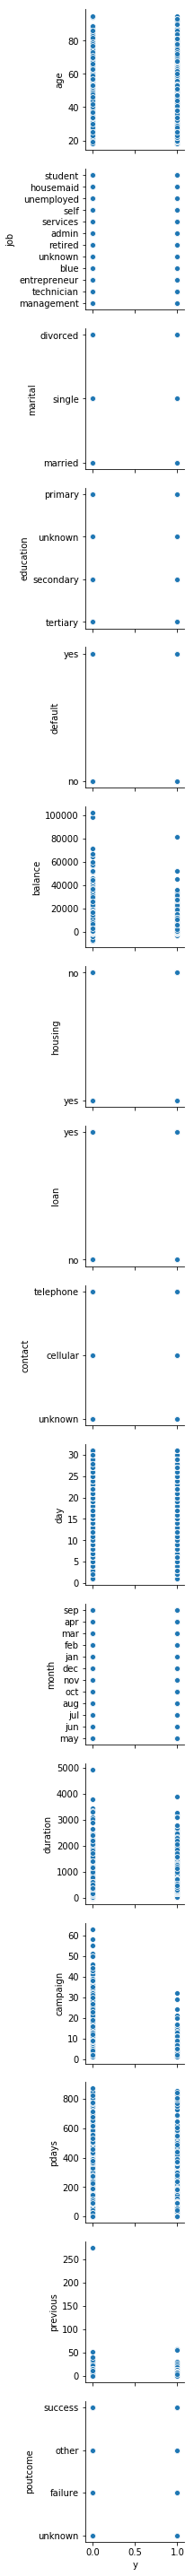

In [3]:
import seaborn as sns
%matplotlib inline

pp = sns.pairplot(data=data,
                  x_vars=['y'],
                  y_vars=data.columns.values[:-1])

## Подготовка признаков

Удалены данные о дате последнего контакта, признак "неизвестный тип контакта", признак "результат предыдущего контака неизвестен", так как они занимают значительную часть выборки, но реальной информации не несут.

In [13]:
import sklearn.preprocessing as preprocess

data = data.dropna()
df = pd.get_dummies(data, columns=['job','education','contact', 'marital', 'poutcome'])

scaler = preprocess.StandardScaler()
scaler.fit_transform(df[['age','balance']])
df[['age','balance']] = scaler.transform(df[['age','balance']])

df[['loan', 'default', 'housing']] = df[['loan', 'default', 'housing']].eq('yes').mul(1)
df = df.drop(columns=['day', 'month', 'contact_unknown', 'poutcome_unknown'])
df = df.dropna()
df.head()

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


,age,default,balance,housing,loan,duration,campaign,pdays,previous,y,...,education_tertiary,education_unknown,contact_cellular,contact_telephone,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
0,1.606965,0,0.256419,1,0,261,1,-1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0.288529,0,-0.437895,1,0,151,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.747384,0,-0.446762,1,1,76,1,-1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.571051,0,0.047205,1,0,92,1,-1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,-0.747384,0,-0.447091,0,0,198,1,-1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [16]:
import sklearn.model_selection as model_selection

y = df['y']
X = df.drop(columns='y')

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.3)

In [17]:
import numpy
from sklearn.linear_model import LogisticRegressionCV

regcv = LogisticRegressionCV(Cs=numpy.arange(-3,3,0.1),n_jobs=-1, cv=5).fit(X_train, y_train)
regcv.C_[0]

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.20000000000000284

## Результаты модели

Показатели качества модели

In [18]:
from sklearn.metrics import classification_report

y_pred = regcv.predict_proba(X_test)[:,1]

print(classification_report(y_test, regcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11941
           1       0.65      0.31      0.42      1623

   micro avg       0.90      0.90      0.90     13564
   macro avg       0.78      0.64      0.68     13564
weighted avg       0.88      0.90      0.88     13564



ТОП-5 признаков

Text(0.5, 1.0, 'Feature importances (Logistic Regression)')

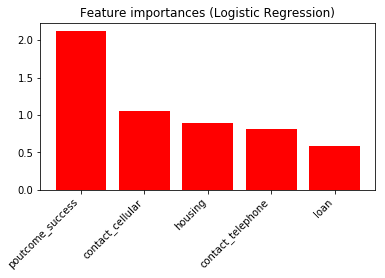

In [19]:
import matplotlib.pyplot as plt

coefs = numpy.abs(regcv.coef_[0])
indices = numpy.argsort(coefs)[::-1]
plt.figure()
plt.bar(range(5), coefs[indices[:5]],
       color="r", align="center")
plt.xticks(range(5), X.keys()[indices[:5]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.title("Feature importances (Logistic Regression)")

### ROC-кривая

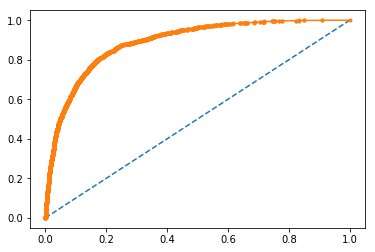

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')

### PR-кривая

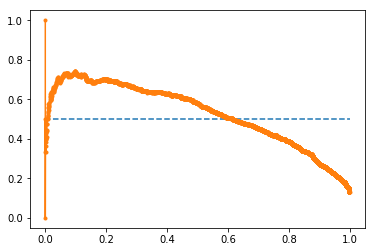

In [21]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')

## Добавление полиномиальных признаков

In [22]:
from sklearn.pipeline import Pipeline

parameters = {'polynomial__degree': range(1,3,1)}

pipeline = Pipeline(steps=[('polynomial',preprocess.PolynomialFeatures()),
                           ('linear', LogisticRegressionCV(Cs=numpy.arange(-3,3,0.1), cv=5, n_jobs=-1))])

grid = model_selection.GridSearchCV(pipeline, parameters, cv=5, n_jobs=1, verbose=False)
grid.fit(X_train, y_train)

y_predCV = grid.predict_proba(X_test)[:,1]

print(classification_report(y_test, grid.predict(X_test)))

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\l

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11941
           1       0.66      0.30      0.42      1623

   micro avg       0.90      0.90      0.90     13564
   macro avg       0.79      0.64      0.68     13564
weighted avg       0.88      0.90      0.88     13564



D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Применение полиномиальных признаков не изменило качество модели.

In [42]:
surprise = pd.read_csv('c.csv')
surprise.groupby('word').count().sort_values('Unnamed: 0', )

,Unnamed: 0
word,
С,3
Днём,5
Рождения!,10
Всего,15
самого,20
наилучшего!,40
